In [1]:
#coding=utf-8
%matplotlib inline
import sys
sys.path.insert(0, '../')

from AircraftIden.StateSpaceIden import StateSpaceIdenSIMO, StateSpaceParamModel

from AircraftIden import FreqIdenSIMO, TransferFunctionFit
import numpy as np
import matplotlib.pyplot as plt
import math
import pickle
import sympy as sp

#Must output pkl with TSCruisingFreqResPitch first!!!
pkl_name = "../data/foam-tail-sitter/cruising/log_34_2018-4-10-freq-res-q.pkl"
finput = open(pkl_name, 'rb')
freq_responses = pickle.load(finput)
def plot_freqres_for_status(freqres , key = "-"):
    
    plt.figure("ele_body_vx")
    freqres.plt_bode_plot(0, label=key+"vx")
    plt.figure("ele_body_vz")
    freqres.plt_bode_plot(1, label=key+"vz")
    plt.figure("ele_body_ax")
    freqres.plt_bode_plot(2, label=key+"ax")
    plt.figure("ele_body_az")
    freqres.plt_bode_plot(3, label=key+"az")
    plt.show()

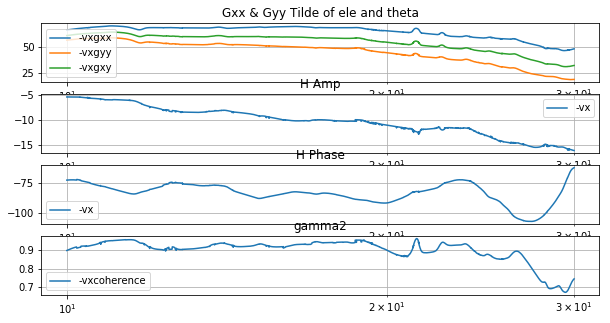

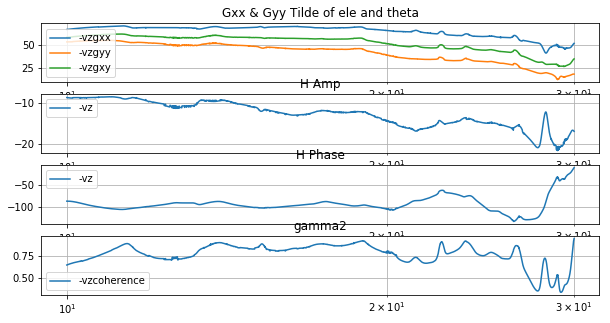

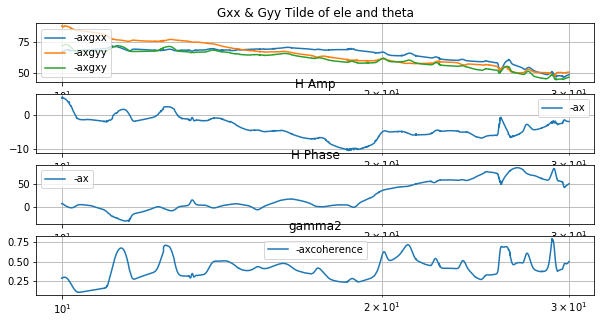

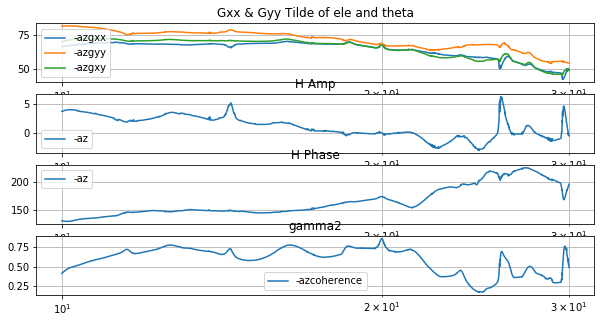

In [2]:
plt.rc('figure', figsize=(10.0, 5.0))
plt.close('all')
freqres_10ms = freq_responses["10m/s"]
plot_freqres_for_status(freqres_10ms)

In [3]:
# X = [u,w,th]
# Y = [u,w]

M = sp.Matrix([[1, 0, 0],
               [0, 1 , 0],
               [0, 0, 1]])

# Tailsittel
#    0---Vx, W
#--- | ----
# |  |  |
#    |
#  Vz ,-U
# 10m/s 

# Vz trim is -6.05,Vz is negative U
# Vx trim is 4.55, Vx is W
g = 9.78
#Th0 in multi mode is -0.95
th0 = 1.57 - 0.95

# Set unknown parameters
Xu, Xw, Xq = sp.symbols('Xu Xw Xq')
Zu, Zw, Zq = sp.symbols('Zu Zw Zq')
Mu, Mw, Mq = sp.symbols('Mu Mw Mq')


def process_ssm(freqres,trims):
    th0 = trims["theta"]
    #Set state space formula
    #AX' = FX + GU
    #y = H0 X+ H1 X'
    F = sp.Matrix([[Xu, Xw, -g * math.cos(th0)],
               [Zu, Zw, -g * math.sin(th0)],
               [0, 0, 0]])
    G = sp.Matrix([[Xq],[Zq],[1]])
    # direct using -u w q for y
    #U equal to negative u
    H0 = sp.Matrix([
        [-1, 0, 0],
        [0, 1, 0]])
    H1 = sp.Matrix([
        [0, 0, 0],
        [0, 0, 0],
    ])
    syms = [Xu, Xw,Zu, Zw,Xq,Zq]
    #Set state space Model with unknow parameters
    LatdynSSPM = StateSpaceParamModel(M, F, G, H0, H1, syms)
    
    plt.rc('figure', figsize=(10.0, 5.0))
    #Act frequency idenification first
    freqres = freqres_10ms.get_freqres(indexs = [1,0])
    
    #Act State space idenification
    ssm_iden = StateSpaceIdenSIMO(freqres, accept_J=150,
                              enable_debug_plot=False,
                              y_names=['U',"w"],reg=0.0 )
    J, ssm = ssm_iden.estimate(LatdynSSPM, syms, constant_defines={})
    
    # Check stable
    ssm.check_stable()
    
    #Draw and print
    ssm_iden.draw_freq_res()
    ssm_iden.print_res()

Process speed 5m/s
Will estimate num 6 [A_0_0, A_0_1, A_1_0, A_1_1, B_0_0, B_1_0]
Found new better 198.39921378921974
Found new better 85.59423955592425
Eigs [  -1.11837582 -581.56385122    0.        ]
Stable
{Xu: -277.980960993657, Xw: -214.440669449413, Zu: -391.953373482315, Zw: -304.701266048257, Xq: -3.74271990031366, Zq: 6.06384616827945}
A
[[-277.98096099 -214.44066945   -4.52310689]
 [-391.95337348 -304.70126605   -8.67121122]
 [   0.            0.            0.        ]]
B
[[-3.7427199 ]
 [ 6.06384617]
 [ 1.        ]]
Process speed 8m/s
Will estimate num 6 [A_0_0, A_0_1, A_1_0, A_1_1, B_0_0, B_1_0]
Found new better 80.65653910218012
Eigs [-0.77981712+1.18988045j -0.77981712-1.18988045j  0.        +0.j        ]
Stable
{Xu: 2.25768232485424, Xw: 3.02986881862813, Zu: -3.51243534768456, Zw: -3.81731655868120, Xq: -4.34254246895153, Zq: 5.54516396594299}
A
[[ 2.25768232  3.02986882 -7.15591714]
 [-3.51243535 -3.81731656 -6.66642707]
 [ 0.          0.          0.        ]]
B
[[-4.3

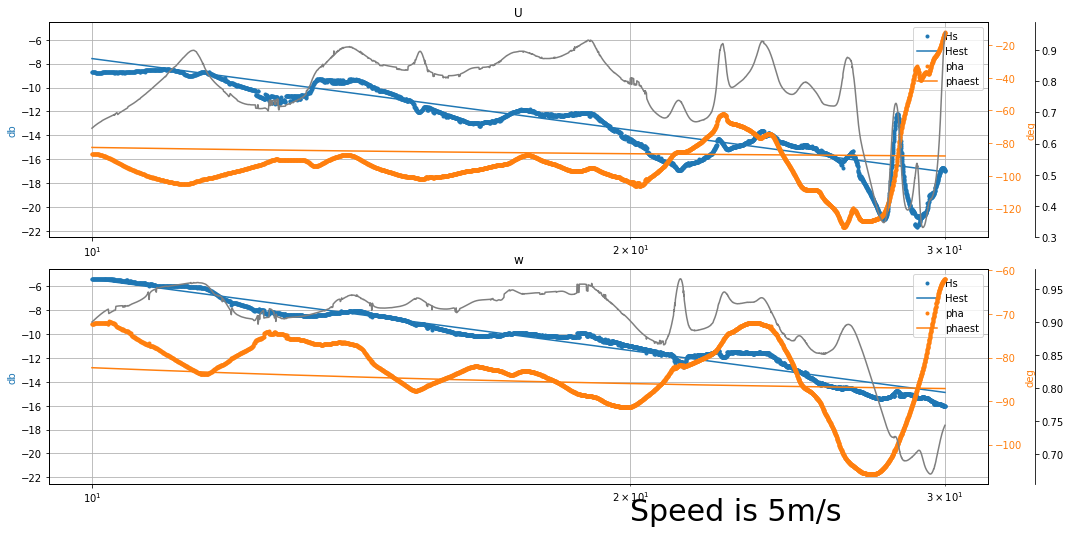

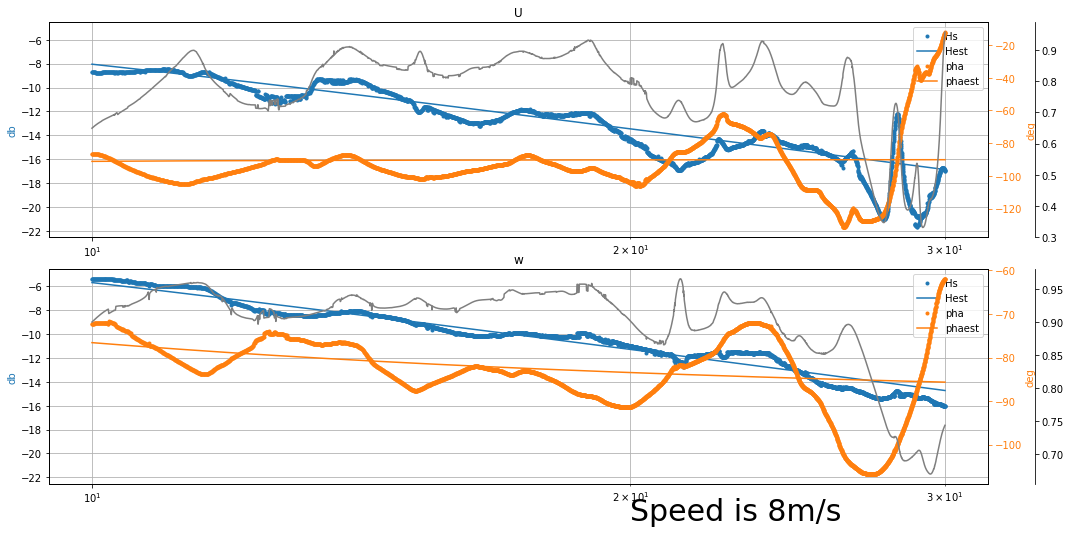

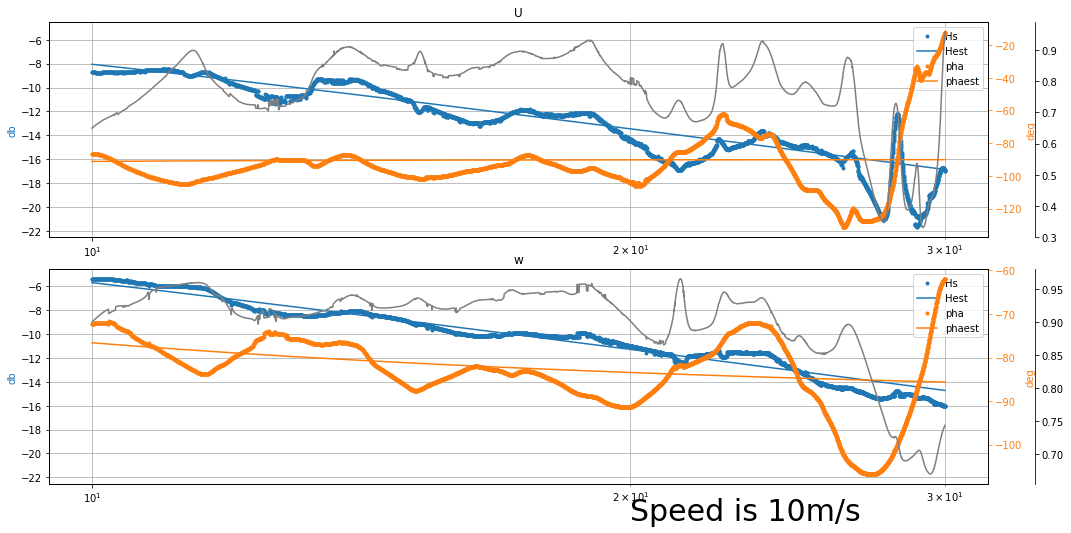

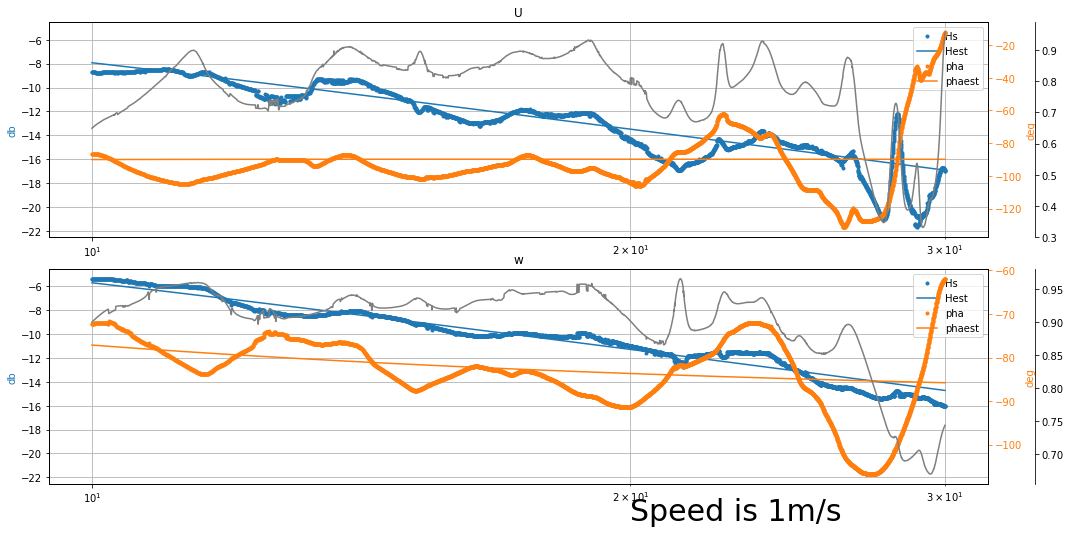

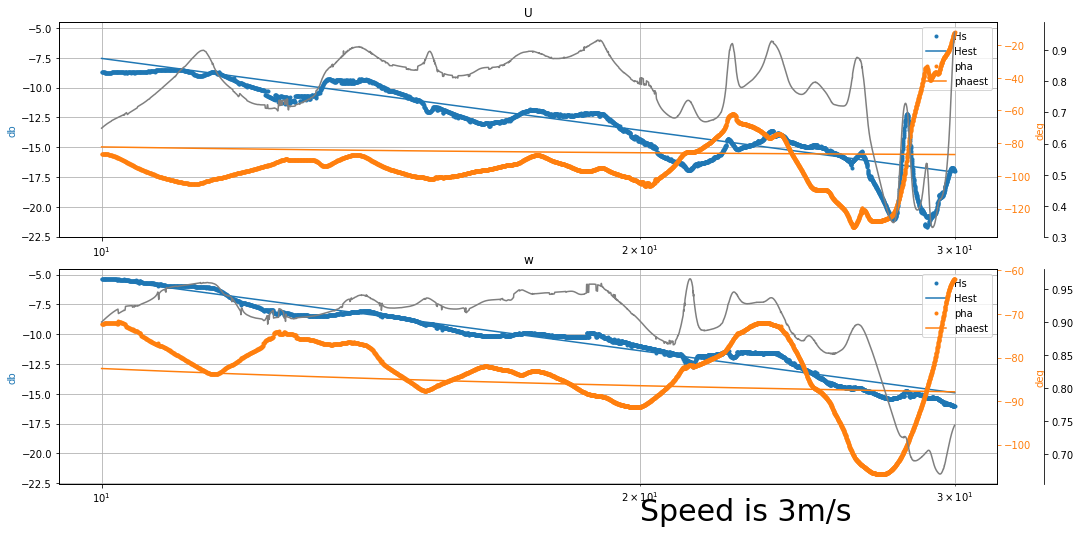

In [11]:
thetas = {
    "10m/s":-0.95,
    "8m/s":-0.82,
    "5m/s":-0.48,
    "3m/s":-0.26,
    "1m/s":-0.11
}
for key in freq_responses:
    print("Process speed {}".format(key))
    process_ssm(freq_responses[key],{"theta":1.57+thetas[key]})
    plt.text(20,0.6,"Speed is {}".format(key), fontsize=30)    

Will estimate num 6 [A_0_0, A_0_1, A_1_0, A_1_1, B_0_0, B_1_0]
Found new better 80.71453726845806
Eigs [-0.53143565+0.9240107j -0.53143565-0.9240107j  0.        +0.j       ]
Stable
{Xu: 2.63286353358807, Xw: 2.82703765011472, Zu: -3.84380629153651, Zw: -3.69573483740654, Xq: -4.33358422317513, Zq: 5.53914663483991}
A
[[ 2.63286353  2.82703765 -4.52310689]
 [-3.84380629 -3.69573484 -8.67121122]
 [ 0.          0.          0.        ]]
B
[[-4.33358422]
 [ 5.53914663]
 [ 1.        ]]


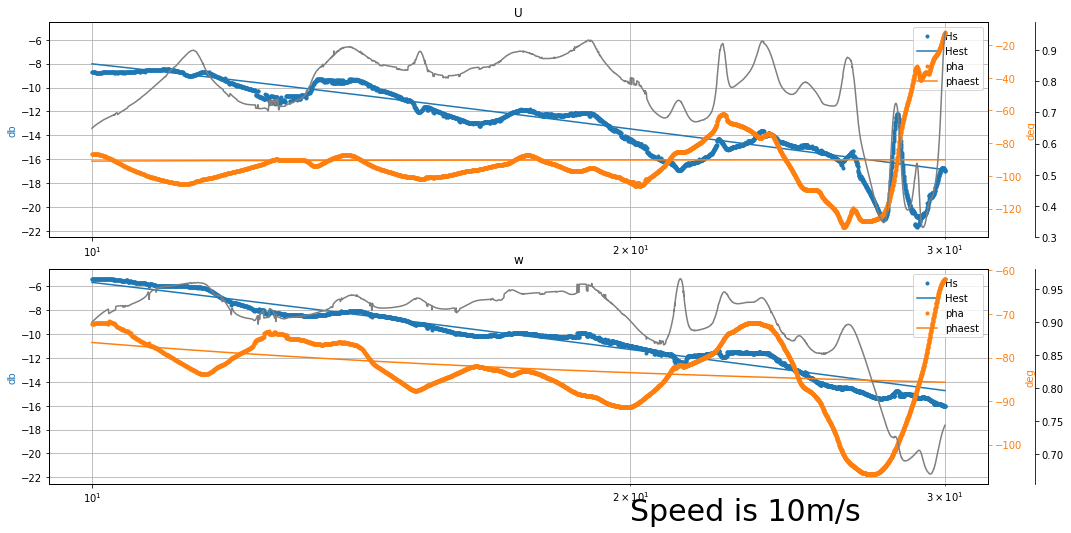

In [10]:
process_ssm(freq_responses["10m/s"],{"theta":1.57+thetas[key]})
_ = plt.text(20,0.6,"Speed is 10m/s", fontsize=30)